In [1]:
import datetime

import numpy as np

from numba import jit

from autograd import elementwise_grad as egrad
from autograd import jacobian
import autograd.numpy as np_

from tqdm import tqdm

import matplotlib.pyplot as plt

#### 1.1 Init parameters


In [2]:

C_ = 0.1 * np.array([1, 1, 1]).reshape(-3,1)

def sigma_1(x):
    return (1 / (1 + 0.22 * np_.exp(-0.2 * np_.matmul(x, C_))) - 0.3)

def sigma_2(x):
    return (1 / (1 + 0.2 * np_.exp(-0.2 * np_.matmul(x, C_))) - 0.2)


x_value = np.array([0.0, 0.0])  # note inputs have to be floats
  # returns a function
#print(H_f(x_value))


def find_Hes(sigma, x):
    H_sigma = jacobian(egrad(sigma))
    length = x.shape[0]
    H_arr = np.full(x.shape[0] * 9, -1.0).reshape(-3, 3, 3)

    
    for i in tqdm(range(length)):
        H = H_sigma(x[i])

        # H_arr[i][:] = H[:] - check result
        H_arr[i,:,:] = H[:,:]

    return H_arr

In [3]:
#hes_1 = find_Hes(sigma_1, x)
#np.save('hes_1.npy', hes_1) 

In [4]:
hes_1 = np.load('hes_1.npy')

In [34]:
def linorm(A):
    return np.sum(np.abs(A)**2)**(1./2)

In [35]:
vnorm = np.vectorize(linorm)

In [36]:
linorm(hes_1[0])

0.00010638726216369257

In [49]:
np.sum(hes_1[:2,:,:]**2, axis=2)

array([[3.77274985e-09, 3.77274985e-09, 3.77274985e-09],
       [3.77221212e-09, 3.77221212e-09, 3.77221212e-09]])

In [71]:
def calc_norms(Hessians):

    length = Hessians.shape[0]
    norms = np.ones(length) 

    for i in range(length):
        norm = np.linalg.norm(Hessians[i])
        norms[i] = norm 

    return norms

def max_H(Hessians, norms):
    max_index = np.argmax(norms)
    
    return Hessians[max_index]

In [62]:
norms_1 = calc_norms(hes_1)

In [69]:
max_H(hes_1, norms_1)

array([[-3.54624207e-05, -3.54624207e-05, -3.54624207e-05],
       [-3.54624207e-05, -3.54624207e-05, -3.54624207e-05],
       [-3.54624207e-05, -3.54624207e-05, -3.54624207e-05]])

In [5]:
#hes_2 = find_Hes(sigma_2, x)
#np.save('hes_2.npy', hes_2) 

In [6]:
hes_2 = np.load('hes_2.npy')

In [53]:
m = 1
n = 3
Tf = 100
Delta_T = 0.0001

TimeSpan = np.arange(0, Tf, Delta_T)
nt = TimeSpan.shape[0] # mt do not use in python 

u = np.fromiter( [ 500 * np.sin(0.00004*i) * np.cos(0.000009*i+1.15) for i in range(nt) ], float )

print('TimeSpan:\n',TimeSpan[:5], '\nnt:\n', nt, '\nu:\n', u[:5])

TimeSpan:
 [0.     0.0001 0.0002 0.0003 0.0004] 
nt:
 1000000 
u:
 [0.         0.00816958 0.01633884 0.02450777 0.03267637]


In [8]:
@jit
def dot_mat_vec(mat, vec, n, m, prod):
    sum = 0
    for i in range(n):
         row = mat[i,:]
         sum = 0
         for j in range(m):
             mult = row[j] * vec[j]
             sum = sum + mult
         prod[i] = sum
    return prod

@jit
def init_x(nt, n, u, A_s, B):
    randoms = np.random.random_sample(3*nt).reshape(nt,-3) * np.array([70, 80, 90])
    m = A_s.shape[0]
    prod = np.zeros(m)
    x = np.zeros((nt,n))

    for j in range(n):
        x[0][j] = 2*(j+1)

    rng = nt - 1
    for i in range(rng):
        cur_x = x[i][:]
        cur_u = u[i]
        cur_rand = randoms[i]

        rand = cur_rand
        fact_A = dot_mat_vec(A_s, cur_x, m, m, prod)
        fact_B = B * cur_u
        fact = cur_x + Delta_T * (fact_A + fact_B + rand)

        x[i+1][:] = fact
    
    return x


def init_x_e(nt, n, u, A_s, B):
    x = np.zeros((nt,n))

    for j in range(n):
        x[0][j] = 2*(j+1)

    A_s = 0.001 * np.diag([-5,-7,-6])
    B = np.array([0, 0, 1])#.reshape(-3, 1)

    for i in range(nt-1):
        u[i] = 500 * np.sin(0.00004*i) * np.cos(0.000009*i+1.15)

        x[i+1][:] = x[i][:] + Delta_T * ( np.matmul(A_s, x[i][:]) + B * u[i] + np.random.random_sample(3) * np.array([70, 80, 90]) )

    return x

def init_x_rk(nt, n, u, A_s, B):
    x = np.zeros((nt,n))
    k_1 = np.zeros((nt,n))
    k_2 = np.zeros((nt,n))
    k_3 = np.zeros((nt,n))
    k_4 = np.zeros((nt,n))
   
    for j in range(n):
        # x[i][:] = 2*(j+1) - check result
        x[0][j] = 2*(j+1)
        k_1[0][j] = 0
        k_2[0][j] = 0
        k_3[0][j] = 0
        k_4[0][j] = 0

    A_s = 0.001 * np.diag([-5,-7,-6])
    B = np.array([0, 0, 1])#.reshape(-3, 1)

    # u(1,i)= 500*sin(0.00004*i)*cos(0.000009*i+1.15);
    # 
    # k_1(:,i) = ( A_s * x(:,i) + B * u(:,i) + [70*rand(1,1);80*rand(1,1);90*rand(1,1)]);
    # 
    # k_2(:,i) = ( A_s * (x(:,i) + 0.5*Delta_T*k_1(:,i) ) + B * u(:,i) + [70*rand(1,1);80*rand(1,1);90*rand(1,1)]);
    #         
    # k_3(:,i) = ( A_s * (x(:,i) + 0.5*Delta_T*k_2(:,i) ) + B * u(:,i) + [70*rand(1,1);80*rand(1,1);90*rand(1,1)]);
    #         
    # k_4(:,i) = ( A_s * (x(:,i) + Delta_T*k_3(:,i) ) + B * u(:,i) + [70*rand(1,1);80*rand(1,1);90*rand(1,1)]);
    #         
    # x(:,i+1) = x(:,i) + Delta_T * (1/6) * (k_1(:,i)+2*k_2(:,i)+2*k_3(:,i)+k_4(:,i));

    for i in range(nt-1):
        u[i] = 500 * np.sin(0.00004*i) * np.cos(0.000009*i+1.15)

        k_1[0][:] = np.matmul(A_s, x[i][:]) + B * u[i] + np.random.random_sample(3) * np.array([70, 80, 90])

        k_2[0][:] = np.matmul( A_s, (x[i][:] + 0.5*Delta_T*k_1[0][:]) ) + B * u[i] + np.random.random_sample(3) * np.array([70, 80, 90])

        k_3[0][:] = np.matmul( A_s, (x[i][:] + 0.5*Delta_T*k_2[0][:]) ) + B * u[i] + np.random.random_sample(3) * np.array([70, 80, 90])

        k_4[0][:] = np.matmul( A_s, (x[i][:] + 0.5*Delta_T*k_3[0][:]) ) + B * u[i] + np.random.random_sample(3) * np.array([70, 80, 90])

        x[i+1][:] = x[i][:] + Delta_T * 0.16666666666666666 * ( k_1[0][:] + 2*k_2[0][:] + 2*k_3[0][:] + k_4[0][:]  )

    return x

In [9]:
A_s = 0.001 * np.diag([-5,-7,-6])
B = np.array([0, 0, 1])

x = init_x(nt, n, u, A_s, B)

In [10]:
x_rk = init_x_rk(nt, n, u, A_s, B)

In [11]:
x_rk

array([[2.00000000e+00, 4.00000000e+00, 6.00000000e+00],
       [2.00253093e+00, 4.00465663e+00, 6.00373423e+00],
       [2.00545694e+00, 4.00642880e+00, 6.00889521e+00],
       ...,
       [2.75507189e+03, 2.87773232e+03, 3.16009540e+03],
       [2.75507427e+03, 2.87773390e+03, 3.16007124e+03],
       [2.75507717e+03, 2.87773833e+03, 3.16004599e+03]])

In [12]:
# %%timeit
# init_x(nt, n, u, A_s, B)
# 30.9 s ± 2.91 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
# 25.6 s ± 3.1 s per loop (mean ± std. dev. of 7 runs, 1 loop each) <- separate calcs in steps 
# 14.6 s ± 703 ms per loop (mean ± std. dev. of 7 runs, 1 loop each) <- separate calcs in steps + generate randoms 
# 1.12 s ± 101 ms per loop (mean ± std. dev. of 7 runs, 1 loop each) <- separate calcs in steps + generate randoms + @numba.jit + custom matrix mult
# 1.08 s ± 120 ms per loop (mean ± std. dev. of 7 runs, 1 loop each) <- separate calcs in steps + generate randoms + @numba.jit + custom fixed matrix mult
# 627 ms ± 96.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each) <- separate calcs in steps + generate randoms + @numba.jit + custom fixed matrix mult+ rm mult

In [13]:
np.mean(x)
# matlab: mean(x, 'all') -> 1.7964e+03

1796.1015376417913

In [14]:
np.mean(x_rk)

1796.1793929371445

In [15]:
x1 = x[:,0]
x2 = x[:,1]
x3 = x[:,2]

x1_rk = x_rk[:,0]
x2_rk = x_rk[:,1]
x3_rk = x_rk[:,2]

In [16]:
x

array([[2.00000000e+00, 4.00000000e+00, 6.00000000e+00],
       [2.00350738e+00, 4.00154287e+00, 6.00089598e+00],
       [2.00564558e+00, 4.00424537e+00, 6.00504095e+00],
       ...,
       [2.75530656e+03, 2.87846457e+03, 3.15726287e+03],
       [2.75530577e+03, 2.87846631e+03, 3.15723679e+03],
       [2.75530841e+03, 2.87847061e+03, 3.15721165e+03]])

In [56]:
x_rk

array([[2.00000000e+00, 4.00000000e+00, 6.00000000e+00],
       [2.00253093e+00, 4.00465663e+00, 6.00373423e+00],
       [2.00545694e+00, 4.00642880e+00, 6.00889521e+00],
       ...,
       [2.75507189e+03, 2.87773232e+03, 3.16009540e+03],
       [2.75507427e+03, 2.87773390e+03, 3.16007124e+03],
       [2.75507717e+03, 2.87773833e+03, 3.16004599e+03]])

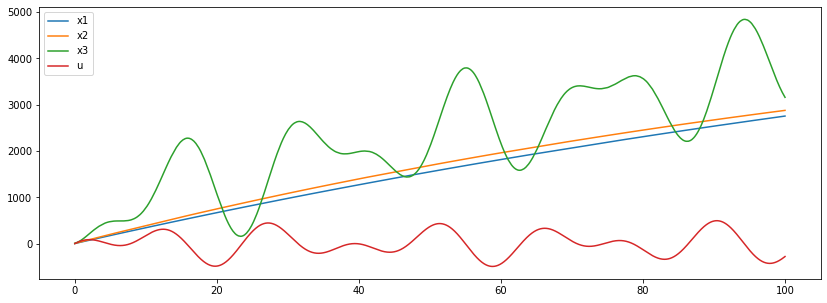

In [17]:
plt.figure(figsize=(14,5)) 

plt.plot(TimeSpan, x1_rk, label='x1')
plt.plot(TimeSpan, x2_rk, label='x2')
plt.plot(TimeSpan, x3_rk, label='x3')
plt.plot(TimeSpan, u, label='u')

plt.legend()

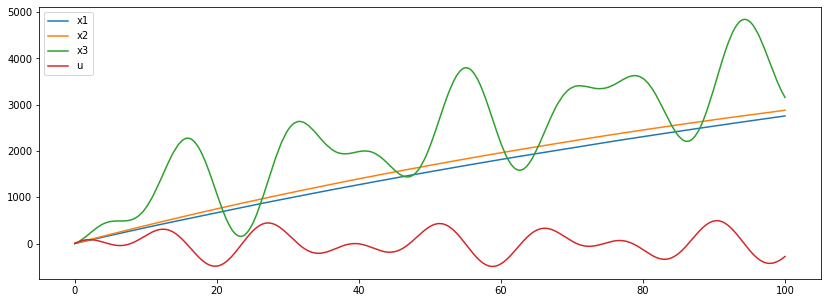

In [18]:
plt.figure(figsize=(14,5)) 

plt.plot(TimeSpan, x1, label='x1')
plt.plot(TimeSpan, x2, label='x2')
plt.plot(TimeSpan, x3, label='x3')
plt.plot(TimeSpan, u, label='u')

plt.legend()

In [19]:
prod = np.zeros(n)
    
print( dot_mat_vec(A_s,  B, 3, 3, prod) ) # 1.37 µs ± 154 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
print( np.matmul(A_s,  B) ) # 3.38 µs ± 621 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
print( np.dot(A_s,  B) ) # 2.71 µs ± 629 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)

[ 0.     0.    -0.006]
[ 0.     0.    -0.006]
[ 0.     0.    -0.006]


#### 2.1 Init parameters for learning law

```matlab

A=diag([-2 -2 -2])*20;              %%User defined

P=diag([60 40 40])*1575.9;           %%User defined or Riccati based solution    

n1=4;                              %%User defined
n2=5;                              %%User defined

xe=9*ones(n,nt);

W1=20*ones(n,n1);
W2=20*ones(n,n2);

W1_S=ones(n,n1,nt);
W2_S=ones(n,n2,nt);

W1_S(:,:,1)=W1(:,:);
W2_S(:,:,1)=W2(:,:);

sigma1=zeros(n1,1,nt);
sigma2=zeros(n2,m,nt);

K1=diag([20,10,20])*0.1;
K2=diag([20,10,20])*0.1;

C=0.1*[1, 1, 1];
```

In [20]:
def calc_nu(Q_0: np.array, P: np.array, eta_sigma: float, eta_phi: float, eta_u: float) -> float:

    P_sqr = np.sqrt(P)
    P_sqr_inv = np.linalg.inv(P_sqr)  # P^(-1/2)


    tmp_matrix = np.matmul(np.matmul(P_sqr_inv, Q_0), P_sqr_inv) # P^(-1/2)*Q_0*P^(-1/2)
    # rewrite using package function - fin min eigvalue
    lambda_min = np.min(linalg.eigvals(tmp_matrix))#.real # min eigvals of matrix P
    
    nu = (eta_sigma + eta_phi*eta_u) / lambda_min
    #return 1
    return nu

def sign_plus(z: float) -> float:
    if z >= 0:
        return z
    else:
        return 0

def s(P: np.array, delta: float, nu: float) -> float:

    P_sqr = np.sqrt(P.astype(np.complex))
    norm_value = linalg.norm(np.matmul(P_sqr, delta)) # find Frobenius matrix norm
    z_value = 1 - nu/norm_value # find z by formula 

    z_value = sign_plus(z_value) # apply sign_plus function 

    #print(z_value)
    return z_value

In [21]:
@jit
def dot_vec_vec(vec_1, vec_2):
    mult = vec_1 * vec_2
    sum = np.sum(mult)
    
    return sum

@jit
def sigma_1(x, C, n):
    #value = (1 / (1 + 0.22 * np.exp(-0.2 * np.matmul(x, C))) - 0.3)
    exp = np.exp( -0.2 * dot_vec_vec(x, C) )
    denom = 1 + 0.22 * exp 
    fact_1 = 1 / denom
    fact_2 = fact_1 - 0.3
    vec = np.ones(n) * fact_2
    
    return vec

@jit
def sigma_2(x, C, n):
    #value = (1 / (1 + 0.2 * np.exp(-0.2 * np.matmul(x, C))) - 0.2)
    exp = np.exp( -0.2 * dot_vec_vec(x, C) )
    denom = 1 + 0.2 * exp 
    fact_1 = 1 / denom
    fact_2 = fact_1 - 0.2
    vec = np.ones(n) * fact_2
    
    return vec

@jit
def sigma_init(arr, C):
    n, _ = arr.shape
    prod_1 = np.zeros((nt,1,n1))
    prod_2 = np.zeros((nt,m,n2))

    for i in range(n):
        x = arr[i][:]

        fact_1 = sigma_1(x, C, n1)
        fact_2 = sigma_2(x, C, n2)

        prod_1[i] = fact_1
        prod_2[i][0] = fact_2

    return (prod_1, prod_2)

In [23]:
A = 20 * np.diag([-2, -2, -2])
P = 1575.9 * np.diag([60, 40, 40])

n1 = 4
n2 = 5

xe = 9 * np.ones((nt,n))

W1 = 20 * np.ones((n,n1))
W2 = 20 * np.ones((n,n2))

W1_S = np.ones((nt,n,n1))
W2_S = np.ones((nt,n,n2))

W1_S[0,:,:] = W1 # check [...]
W2_S[0,:,:] = W2 

K1 = 0.1 * np.diag([20, 10, 20])
K2 = 0.1 * np.diag([20, 10, 20])

C = 0.1 * np.array([1, 1, 1]).reshape(-3,1)

sigma1 = np.zeros((nt,1,n1))
sigma2 = np.zeros((nt,m,n2))

C_T = C.T
#sigma1, sigma2 = sigma_init(x, C_T) # 1.66 s ± 17.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

print('xe:\n', xe, '\nW1:\n', W1, '\nW2:\n', W2, '\nW1_S:\n', W1_S[1], '\nW2_S:\n', W2_S[1], '\nsigma1:\n', sigma1[0], '\nsigma2:\n', sigma1[0], '\nK1:\n', K1)

xe:
 [[9. 9. 9.]
 [9. 9. 9.]
 [9. 9. 9.]
 ...
 [9. 9. 9.]
 [9. 9. 9.]
 [9. 9. 9.]] 
W1:
 [[20. 20. 20. 20.]
 [20. 20. 20. 20.]
 [20. 20. 20. 20.]] 
W2:
 [[20. 20. 20. 20. 20.]
 [20. 20. 20. 20. 20.]
 [20. 20. 20. 20. 20.]] 
W1_S:
 [[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]] 
W2_S:
 [[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]] 
sigma1:
 [[0. 0. 0. 0.]] 
sigma2:
 [[0. 0. 0. 0.]] 
K1:
 [[2. 0. 0.]
 [0. 1. 0.]
 [0. 0. 2.]]


1000000

\begin{equation}
R=2 \bar{W}_{1}+2 \bar{W}_{2}, \quad Q=Q_{0}+\Lambda_{\sigma}+\Lambda_{\phi} \bar{u}
\end{equation}

#### 2.2 Start learning law


In [24]:
K1_P = np.matmul(K1,P)
K2_P = np.matmul(K1,P)

In [25]:
@jit
def ll(xe, A, W1, W2, W1_S, W2_S, K1_P, K2_P, sigma1, sigma2, u, nt):
    m = 3
    prod = np.zeros(m)
    Delta = 0

    for i in range(nt):

        Delta = xe - x 
        
        cur_u = u[i]
        cur_xe = xe[i]
        cur_delta = Delta[i]
        cur_sigma_1 = sigma1[i][0]
        cur_sigma_2 = sigma2[i][0]

        A_xe = dot_mat_vec( A, cur_xe, m, m, prod ) 
        W_sigma_1 = dot_mat_vec( W1, cur_sigma_1, m, 4, prod ) 
        W_sigma_2 = dot_mat_vec( W2, cur_sigma_2, m, 5, prod ) 

        xe[i+1] = xe[i] + Delta_T * (A_xe + W_sigma_1 + W_sigma_2 * cur_u)

        mat_mult_1 = dot_mat_vec( K1_P, cur_delta, m, m, prod ) 
        reshape_1 = mat_mult_1.reshape(-3,1)
        mult_1 = Delta_T * reshape_1 * cur_sigma_1

        W1 = W1 - mult_1

        mat_mult_2 = dot_mat_vec( K2_P, cur_delta, m, m, prod ) 
        reshape_2 = mat_mult_2.reshape(-3,1)
        mult_2 = Delta_T * reshape_2 * cur_u * cur_sigma_2

        W2 = W2 - mult_2

        W1_S[i+1] = W1
        W2_S[i+1] = W2

    return xe 


def ll_e(xe, A, W1, W2, W1_S, W2_S, K1_P, K2_P, sigma1, sigma2, u, nt):

    for i in range(nt-1):

        # Sigma 1
        for j in range(n1):
            sigma1[0][0][j] = (1 / (1 + 0.22 * np.exp(-0.2 * np.matmul(x[i], C))) - 0.3)
        
        # Sigma 2
        # rewrite sigma[j,:] = ...
        for j in range(n2):
            for k in range(m):
                sigma2[k][0][j] = (1 / (1 + 0.2 * np.exp(-0.2 * np.matmul(x[i], C))) - 0.2)

        # rewrite for i-th
        Delta = xe - x 

        xe[i+1] = xe[i] + Delta_T * (np.matmul(A, xe[i]) + np.matmul(W1, sigma1[0][0]) + np.matmul(W2, sigma2[i][0]) * u[i+1])

        W1 = W1 - Delta_T * (np.matmul( np.matmul(K1,P), Delta[i] ).reshape(-3,1) * sigma1[0][0])
        W2 = W2 - Delta_T * (np.matmul( np.matmul(K2,P), Delta[i] ).reshape(-3,1) * u[i+1] * sigma2[i][0])

        # ?? How use for t > TimeSpan ?? 
        W1_S[i+1] = W1
        W2_S[i+1] = W2

    return xe



def ll_rk(xe, A, W1, W2, W1_S, W2_S, K1_P, K2_P, sigma1, sigma2, u, nt):

    for i in range(nt-1):

        # FOR k_1

        # Sigma 1
        for j in range(n1):
            sigma1[0][0][j] = (1 / (1 + 0.22 * np.exp(-0.2 * np.matmul(x[i], C))) - 0.3)
        
        # Sigma 2
        for j in range(n2):
            for k in range(m):
                sigma2[k][0][j] = (1 / (1 + 0.2 * np.exp(-0.2 * np.matmul(x[i], C))) - 0.2)

        
        k_1 = np.matmul(A, xe[i]) + np.matmul(W1, sigma1[0][0]) + np.matmul(W2, sigma2[i][0]) * u[i+1]

        # FOR k_2
        
        # Sigma 1
        for j in range(n1):
            sigma1[0][0][j] = (1 / (1 + 0.22 * np.exp(-0.2 * np.matmul( (x[i] + 0.5*Delta_T*k_1), C)) - 0.3) )
         
        # Sigma 2
        for j in range(n2):
            for k in range(m):
                sigma2[k][0][j] = (1 / (1 + 0.2 * np.exp(-0.2 * np.matmul( (x[i] + 0.5*Delta_T*k_1), C))) - 0.2)

        k_2 =  np.matmul(A, (x[i] + 0.5*Delta_T*k_1) ) + np.matmul(W1, sigma1[0][0]) + np.matmul(W2, sigma2[i][0]) * u[i+1]

        # FOR k_3
        
        # Sigma 1
        for j in range(n1):
            sigma1[0][0][j] = (1 / (1 + 0.22 * np.exp(-0.2 * np.matmul( (x[i] + 0.5*Delta_T*k_2), C)) - 0.3) )
         
        # Sigma 2
        for j in range(n2):
            for k in range(m):
                sigma2[k][0][j] = (1 / (1 + 0.2 * np.exp(-0.2 * np.matmul( (x[i] + 0.5*Delta_T*k_2), C))) - 0.2)

        k_3 =  np.matmul(A, (x[i] + 0.5*Delta_T*k_2) ) + np.matmul(W1, sigma1[0][0]) + np.matmul(W2, sigma2[i][0]) * u[i+1]

        # FOR k_4
        
        # Sigma 1
        for j in range(n1):
            sigma1[0][0][j] = (1 / (1 + 0.22 * np.exp(-0.2 * np.matmul( (x[i] + Delta_T*k_3), C)) - 0.3) )
         
        # Sigma 2
        for j in range(n2):
            for k in range(m):
                sigma2[k][0][j] = (1 / (1 + 0.2 * np.exp(-0.2 * np.matmul( (x[i] + Delta_T*k_3), C))) - 0.2)

        k_4 =  np.matmul(A, (x[i] + Delta_T*k_3) ) + np.matmul(W1, sigma1[0][0]) + np.matmul(W2, sigma2[i][0]) * u[i+1]

        #print(k_1)
        #print(k_2)
        #print(k_3)
        #print(k_4)

        xe[i+1] = xe[i] + Delta_T * 0.16666666666666666 * ( k_1 + 2*k_2 + 2*k_3 + k_4  )

        Delta = xe - x 

        W1 = W1 - Delta_T * (np.matmul( np.matmul(K1,P), Delta[i] ).reshape(-3,1) * sigma1[0][0])
        W2 = W2 - Delta_T * (np.matmul( np.matmul(K2,P), Delta[i] ).reshape(-3,1) * u[i+1] * sigma2[i][0])

        # ?? How use for t > TimeSpan ?? 
        W1_S[i+1] = W1
        W2_S[i+1] = W2

    return xe

In [78]:
xe_e = ll_e(xe, A, W1, W2, W1_S, W2_S, K1_P, K2_P, sigma1, sigma2, u, 101)

In [81]:
start = datetime.datetime.now()
xe_rk = ll_rk(xe, A, W1, W2, W1_S, W2_S, K1_P, K2_P, sigma1, sigma2, u, 101) # 1.28 s ± 186 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
end = datetime.datetime.now()
print('Work time of exec = {}'.format(end-start))

Work time of exec = 0:00:02.768611


In [74]:
xe_rk[100]

array([-8.25278918,  8.60657116,  6.46638591])

In [82]:
xe_rk[100]

array([-8.25278918,  8.60657116,  6.46638591])

In [75]:
xe_e[100]

array([-8.25278918,  8.60657116,  6.46638591])

In [76]:
xe = np.load('xe_data.npy')

In [77]:
xe[100]

array([3.40111971, 0.09268993, 5.07363069])

In [86]:
xe_e[-1]

array([2757.59233896, 2879.65542822, 3160.79950293])

In [22]:
#%%timeit
start = datetime.datetime.now()
xe_ = ll(xe, A, W1, W2, W1_S, W2_S, K1_P, K2_P, sigma1, sigma2, u, nt) # 1.28 s ± 186 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
end = datetime.datetime.now()
print('Work time of exec = {}'.format(end-start))

Work time of exec = 3:40:22.381732


In [23]:
#%%timeit
start_c = datetime.datetime.now()
xe_c = ll_c(xe, A, W1, W2, W1_S, W2_S, K1_P, K2_P, sigma1_c, sigma2_c, u, nt) # 1.13 s ± 182 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
end_c = datetime.datetime.now()
print('Work time of exec = {}'.format(end_c-start_c))

Work time of exec = 2:47:33.063432


In [19]:
#for i in range(nt-1):
#
#    # Sigma 1
#    for j in range(n1):
#        sigma1[0][0][j] = (1 / (1 + 0.22 * np.exp(-0.2 * np.matmul(x[i], C))) - 0.3)
#    
#    # Sigma 2
#    for j in range(n2):
#        for k in range(m):
#            sigma2[k][0][j] = (1 / (1 + 0.2 * np.exp(-0.2 * np.matmul(x[i], C))) - 0.2)
#
#    Delta = xe - x 
#
#    xe[i+1] = xe[i] + Delta_T * (np.matmul(A, xe[i]) + np.matmul(W1, sigma1[0][0]) + np.matmul(W2, sigma2[i][0]) * u[i+1])
#
#    W1 = W1 - Delta_T * (np.matmul( np.matmul(K1,P), Delta[i] ).reshape(-3,1) * sigma1[0][0])
#    W2 = W2 - Delta_T * (np.matmul( np.matmul(K2,P), Delta[i] ).reshape(-3,1) * u[i+1] * sigma2[i][0])
#
#    # ?? How use for t > TimeSpan ?? 
#    W1_S[i+1] = W1
#    W2_S[i+1] = W2

#### 2.3 Plot results


In [45]:
xe1 = xe_e[:,0]
xe2 = xe_e[:,1]
xe3 = xe_e[:,2]

xe_rk1 = xe_rk[:,0]
xe_rk2 = xe_rk[:,1]
xe_rk3 = xe_rk[:,2]

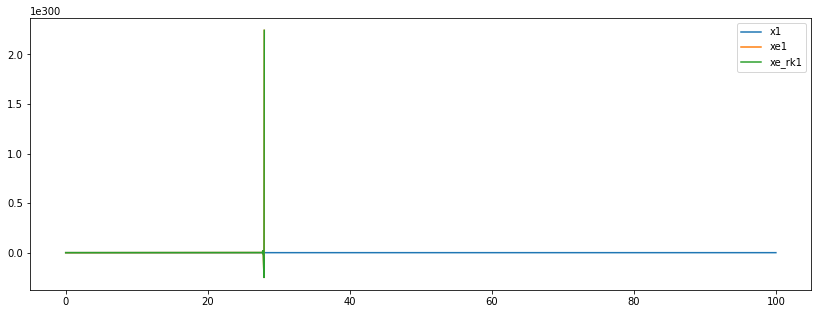

In [47]:
plt.figure(figsize=(14,5)) 

plt.plot(TimeSpan, x1, label='x1')
plt.plot(TimeSpan, xe1, label='xe1')
plt.plot(TimeSpan, xe_rk1, label='xe_rk1')

plt.legend()

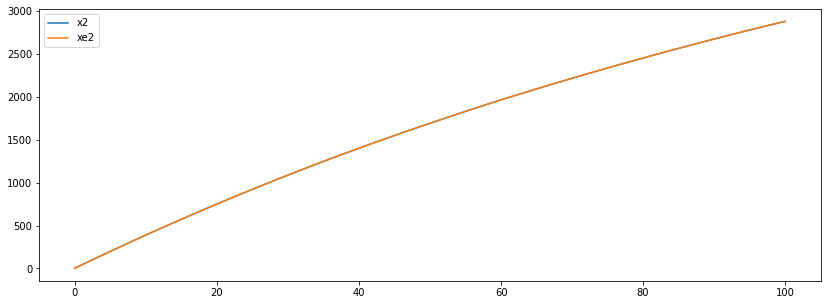

In [26]:
plt.figure(figsize=(14,5)) 

plt.plot(TimeSpan, x2, label='x2')
plt.plot(TimeSpan, xe2, label='xe2')

plt.legend()

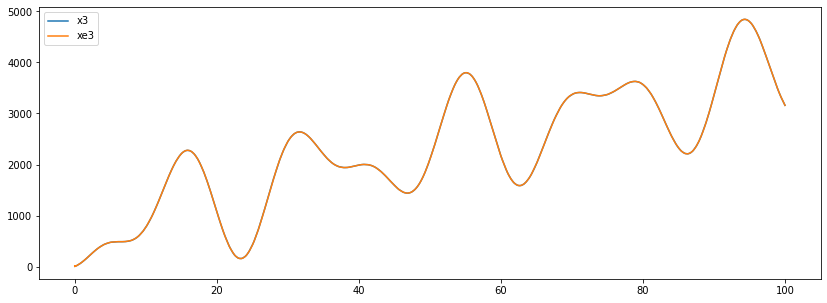

In [27]:
plt.figure(figsize=(14,5)) 
#[:6000]
plt.plot(TimeSpan, x3, label='x3')
plt.plot(TimeSpan, xe3, label='xe3')

plt.legend()

In [23]:
new_num_arr = np.load('xe_data_v2.npy')

In [22]:
np.save('xe_data_v2.npy', xe) 

In [17]:
#for i in range(nt):
#
#    # Sigma 1
#    for j in range(n1):
#        sigma1[i][0][j] = (1 / (1 + 0.22 * np.exp(-0.2 * np.matmul(x[i], C))) - 0.3)
#
#    # Sigma 2
#    for j in range(n2):
#        sigma2[i][0][j] = (1 / (1 + 0.2 * np.exp(-0.2 * np.matmul(x[i], C))) - 0.2)

In [18]:
# %%timeit
# dot_vec_vec(x[0][:], C) -> 2.07 µs ± 212 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
# np.dot(x[0][:], C) -> 2.76 µs ± 641 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
# np.matmul(x[0][:], C) -> 4.03 µs ± 932 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)

In [53]:
! ls

0 - task.ipynb     3 - task opt.ipynb hes_2.npy
1 - task.ipynb     DNN_MF.m           test.py
2 - task.ipynb     hes_1.npy          xe_data.npy
